In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import bartlett
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

Question 2: Is there a connection between winning awards and a movies profitability (gross revenue / budget)?

In [3]:
# Load CSV
df = pd.read_csv("juroe_project_proposal.csv", encoding = "UTF-8")

In [4]:
# Add profitability column
df['profitability'] = df['gross'] / df['budget']

In [5]:
display(df)

,Rank,Movie Title,Wins,Nominations,year,rating,genre,score,votes,country,budget,gross,company,runtime,profitability
0,1,The Shawshank Redemption,21,42,1994,R,Drama,9.3,2400000.0,United States,25000000.0,2.881729e+07,Castle Rock Entertainment,142.0,1.152692
1,3,The Dark Knight,164,165,2008,PG-13,Action,9.0,2400000.0,United States,185000000.0,1.005974e+09,Warner Bros.,152.0,5.437695
2,6,The Lord of the Rings: The Return of the King,215,124,2003,PG-13,Action,8.9,1700000.0,New Zealand,94000000.0,1.146031e+09,New Line Cinema,201.0,12.191818
3,7,Schindler's List,91,49,1993,R,Biography,8.9,1200000.0,United States,22000000.0,3.221612e+08,Universal Pictures,195.0,14.643693
4,8,Pulp Fiction,69,72,1994,R,Crime,8.9,1900000.0,United States,8000000.0,2.139288e+08,Miramax,154.0,26.741095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,244,Into the Wild,13,6,2007,R,Adventure,8.1,588000.0,United States,15000000.0,5.667590e+07,Paramount Vantage,148.0,3.778393
138,246,Groundhog Day,7,17,1993,PG,Comedy,8.0,589000.0,United States,14600000.0,7.107405e+07,Columbia Pictures,101.0,4.868086
139,247,The Help,79,121,2011,PG-13,Drama,8.0,436000.0,United States,25000000.0,2.166391e+08,DreamWorks,146.0,8.665564
140,248,Amores Perros,55,24,2000,R,Drama,8.1,228000.0,Mexico,2000000.0,2.090847e+07,Altavista Films,154.0,10.454234


### Hypothesis Test: Bartlett's Test for equal variance
H<sub>0</sub>: The varainces are equal

In [7]:
high_wins = df[df['Wins'] >= df['Wins'].median()]['profitability']
low_wins = df[df['Wins'] < df['Wins'].median()]['profitability']

stat, p_value = bartlett(high_wins, low_wins)
print(f"Bartlett's Test: stat={stat:.4f}, p_value={p_value:.4f}")

alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject H0: The variances are significantly different.")
else:
    print("Fail to reject H0: The variances are not significantly different.")

Bartlett's Test: stat=0.0145, p_value=0.9042
Fail to reject H0: The variances are not significantly different.


### Pearson Correlation (Linear Correlation)
Correlation measures the **strength and direction of the linear relationship** between two continuous variables (e.g., Wins vs. profitability).

In [9]:
# calculate Pearson correlation between 'budget' and 'nominations'
pearson_corr = df["Wins"].corr(df["profitability"], method="pearson")

# display the result
print(f"Pearson Correlation: {pearson_corr:.4f}")

# interpretation
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation.")
else:
    print("Interpretation: Strong linear correlation.")

Pearson Correlation: 0.1630
Interpretation: No or weak linear correlation.


### Machine Learning Technique
Linear regression between profitability and awards won

Linear Regression Coeff: 0.0260, Intercept: 6.8356
R^2 Score: 0.0266


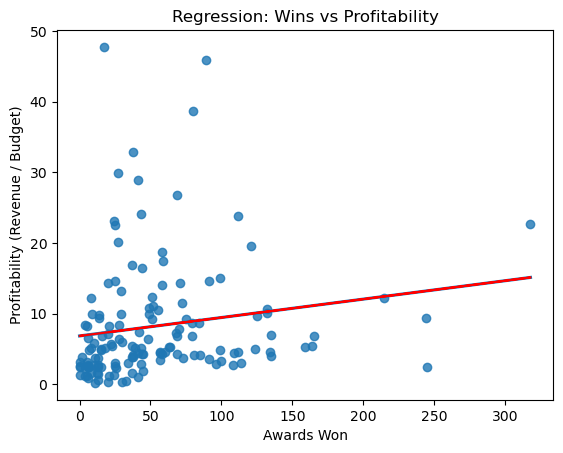

In [11]:
X = df[['Wins']]
y = df['profitability']
model = LinearRegression().fit(X, y)
print(f"Linear Regression Coeff: {model.coef_[0]:.4f}, Intercept: {model.intercept_:.4f}")
print(f"R^2 Score: {r2_score(y, model.predict(X)):.4f}")

# Visualization
sns.regplot(x='Wins', y='profitability', data=df, ci=None)
plt.title('Regression: Wins vs Profitability')
plt.xlabel('Awards Won')
plt.ylabel('Profitability (Revenue / Budget)')
plt.plot(X, model.predict(X), color='red')
plt.show()

In [12]:
# Remove Outliers from the data
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 2 * IQR
    upper = Q3 + 2 * IQR
    print(f"{column} bounds: {lower:.2f} to {upper:.2f}")
    return df[(df[column] >= lower) & (df[column] <= upper)]

profitability bounds: -10.78 to 23.70
Wins bounds: -100.00 to 185.00
R^2 for Nominations (after outlier removal): 0.0317


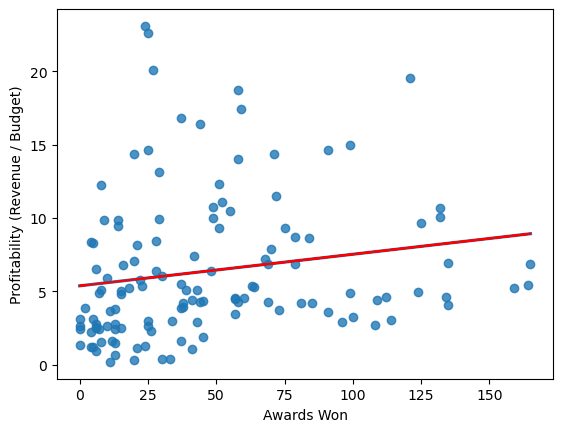

In [13]:
# Updated Wins vs. profitability Regression
df_new = remove_outliers_iqr(df, "profitability")
df_new = remove_outliers_iqr(df_new, "Wins")

X = df_new[["Wins"]]
y = df_new["profitability"]

model_new = LinearRegression().fit(X, y)
r2_new = r2_score(y, model_new.predict(X))
print(f"R^2 for Nominations (after outlier removal): {r2_new:.4f}")

# Visualization
sns.regplot(x='Wins', y='profitability', data=df_new, ci=None)
plt.xlabel("Awards Won")
plt.ylabel("Profitability (Revenue / Budget)")
plt.plot(X, model_new.predict(X), color='red')
plt.show()

The R-squared for the linear regression is very weak, 0.0266 for the original data, and 0.0317 after outliers were removed.

### Time-Series Forecast
How profitability of movies has changed over the years

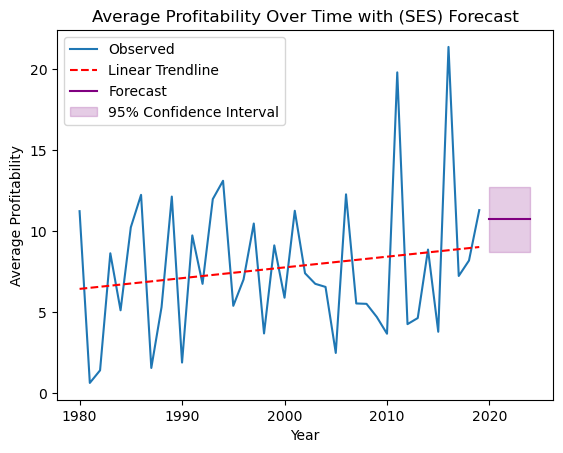

In [16]:
yearly_avg = df.groupby('year')['profitability'].mean().dropna().reset_index()

# Fit linear trendline
z = np.polyfit(yearly_avg['year'], yearly_avg['profitability'], 1)
p = np.poly1d(z)

# Forecast next 5 years (Linear Forecast)
future_years = np.arange(yearly_avg['year'].max() + 1, yearly_avg['year'].max() + 6)
future_profitability = p(future_years)

# Simple Exponential Smoothing Forecast
ses_model = SimpleExpSmoothing(yearly_avg['profitability']).fit(smoothing_level=0.8, optimized=False)
ses_forecast = ses_model.forecast(5)

# Calculate 95% confidence interval for SES (approximate)
ses_se = np.std(ses_model.resid) / np.sqrt(len(yearly_avg))
ci_upper = ses_forecast + 1.96 * ses_se
ci_lower = ses_forecast - 1.96 * ses_se

#Visualize
plt.plot(yearly_avg['year'], yearly_avg['profitability'], label='Observed')
plt.plot(yearly_avg['year'], p(yearly_avg['year']), linestyle='--', color='red', label='Linear Trendline')
plt.plot(future_years, ses_forecast, linestyle='-', color='purple', label='Forecast')
plt.fill_between(future_years, ci_lower, ci_upper, color='purple', alpha=0.2, label='95% Confidence Interval')

plt.title('Average Profitability Over Time with (SES) Forecast')
plt.xlabel('Year')
plt.ylabel('Average Profitability')
plt.legend()
plt.show()